In [56]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn
from torch import nn, optim

# Transform for the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load MNIST dataset
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

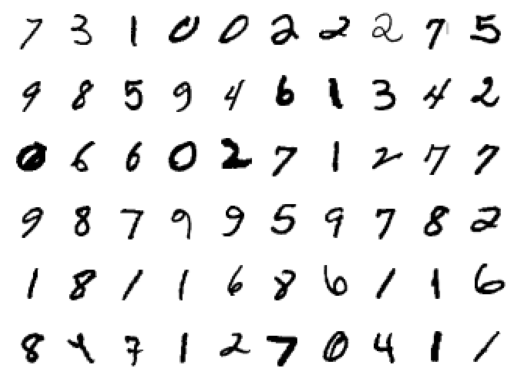

In [16]:
figure = plt.figure()
num_of_images = 60

dataiter = iter(trainloader)
images, labels = next(dataiter)

for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Own Implementation for the Classifier

In [60]:
class MySGD:
    def __init__(self, params, lr):
        self.params = params  # List of parameters (weights and biases)
        self.lr = lr          # Learning rate

    def step(self, gradients):
        # Update parameters using the computed gradients
        for param, grad in zip(self.params, gradients):
            param -= self.lr * grad


In [61]:
class NeuralNetwork:
    torch.manual_seed(84)
    
    def __init__(self, input_size, hidden_layers, output_size, learning_rate):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.activation_function = self.sigmoid
        self.learning_rate = learning_rate

        # Initialize weights and biases
        self.weights = [torch.randn(input_size, hidden_layers[0])]
        self.biases = [torch.zeros(hidden_layers[0])]

        for i in range(1, len(hidden_layers)):
            self.weights.append(torch.randn(hidden_layers[i-1], hidden_layers[i]))
            self.biases.append(torch.zeros(hidden_layers[i]))

        self.weights.append(torch.randn(hidden_layers[-1], output_size))
        self.biases.append(torch.zeros(output_size))

        # Combine weights and biases into a single list of parameters
        self.params = []
        for w, b in zip(self.weights, self.biases):
            self.params.extend([w, b])

        # Initialize the optimizer
        self.optimizer = MySGD(self.params, self.learning_rate)

    def sigmoid(self, x):
        return 1 / (1 + torch.exp(-x))

    def softmax(self, x):
        exp_values = torch.exp(x - torch.max(x, dim=1, keepdim=True)[0])
        return exp_values / torch.sum(exp_values, dim=1, keepdim=True)

    def relu(self, x):
        return torch.max(x, torch.zeros_like(x))

    def forward(self, x):
        self.inputs = [x]
        self.z_values = []
        self.activations = []

        # Forward propagation
        for i in range(len(self.hidden_layers) + 1):
            z = torch.matmul(x, self.weights[i]) + self.biases[i]
            self.z_values.append(z)

            if i == len(self.hidden_layers):
                x = self.softmax(z)
            else:
                x = self.activation_function(z)

            self.inputs.append(x)
            self.activations.append(x)

        return x

    def backward(self, output, target):
        # Backward propagation
        gradients = []
        delta = output - target  # Assuming softmax output and cross-entropy loss

        for i in reversed(range(len(self.weights))):
            activation_prev = self.activations[i - 1] if i > 0 else self.inputs[0]
            weight_grad = torch.mm(activation_prev.t(), delta)
            bias_grad = torch.sum(delta, dim=0)

            gradients.insert(0, bias_grad)
            gradients.insert(0, weight_grad)

            if i != 0:
                delta = torch.mm(delta, self.weights[i].t()) * self.activations[i - 1] * (1 - self.activations[i - 1])

        # Update parameters using the optimizer
        self.optimizer.step(gradients)

    def train(self, train_loader, epochs):
        loss_history = []
        for epoch in range(epochs):
            for inputs, labels in train_loader:
                inputs = inputs.view(inputs.shape[0], -1)
                labels_one_hot = torch.eye(self.output_size)[labels]

                output = self.forward(inputs)
                loss = torch.mean((output - labels_one_hot) ** 2)
                self.backward(output, labels_one_hot)

            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')
            loss_history.append(loss.item())

        return loss_history

    def test(self, val_loader):
        correct = 0
        total = 0

        for inputs, labels in val_loader:
            inputs = inputs.view(inputs.shape[0], -1)
            outputs = self.forward(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f'Test Accuracy: {accuracy * 100:.2f}%')


In [66]:
# Hyperparameters
input_size = 784
hidden_sizes = [128, 64]
output_size = 10
learning_rate = 0.01
epochs = 15

# Initialize and train the neural network with the ReLU activation function
nn = NeuralNetwork(input_size, hidden_sizes, output_size, learning_rate)
loss_own = nn.train(trainloader, epochs)

Epoch 1/15, Loss: 0.027652153745293617
Epoch 2/15, Loss: 0.012860411778092384
Epoch 3/15, Loss: 0.018795816227793694
Epoch 4/15, Loss: 0.020678384229540825
Epoch 5/15, Loss: 0.012524118646979332
Epoch 6/15, Loss: 0.011374817229807377
Epoch 7/15, Loss: 0.011309908702969551
Epoch 8/15, Loss: 0.003746164496988058
Epoch 9/15, Loss: 0.005970737896859646
Epoch 10/15, Loss: 0.007398319896310568
Epoch 11/15, Loss: 0.016431007534265518
Epoch 12/15, Loss: 0.0024084378965198994
Epoch 13/15, Loss: 0.004886594135314226
Epoch 14/15, Loss: 0.0007085447432473302
Epoch 15/15, Loss: 0.011805743910372257


In [67]:
nn.test(valloader)

Test Accuracy: 94.32%


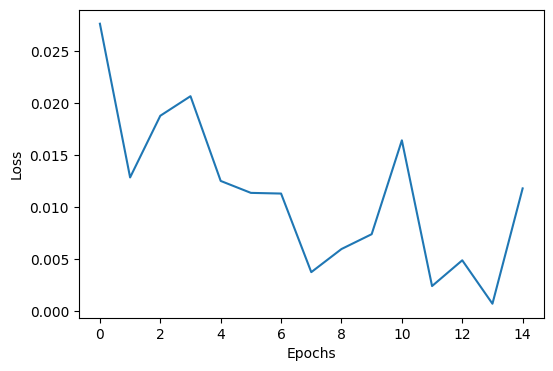

In [69]:
plt.figure(figsize=(6, 4))
plt.plot(range(15), loss_own)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("mnist_loss_own.pdf", format="pdf")

# With Optimizer

In [53]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [54]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [57]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
loss_optim = []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        loss_optim.append(running_loss/len(trainloader))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.6633668215131201
Epoch 1 - Training loss: 0.2831607709990254
Epoch 2 - Training loss: 0.2185937364432794
Epoch 3 - Training loss: 0.1754284104916142
Epoch 4 - Training loss: 0.14418030458528286
Epoch 5 - Training loss: 0.12249315422631975
Epoch 6 - Training loss: 0.10822980610856306
Epoch 7 - Training loss: 0.09551994664284752
Epoch 8 - Training loss: 0.08543999009291088
Epoch 9 - Training loss: 0.07791053361223657
Epoch 10 - Training loss: 0.07068159945978364
Epoch 11 - Training loss: 0.06537489773137674
Epoch 12 - Training loss: 0.05912356239074329
Epoch 13 - Training loss: 0.05510436639071567
Epoch 14 - Training loss: 0.04988752085733404

Training Time (in minutes) = 2.7096789677937827


In [58]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9717


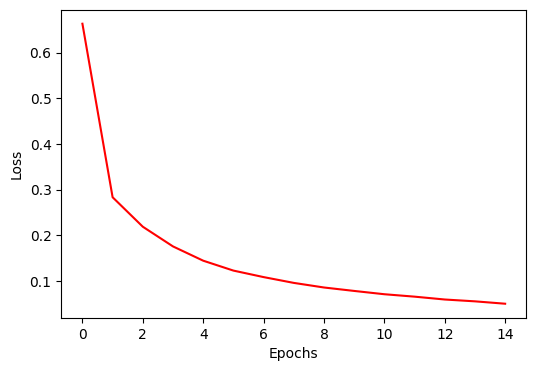

In [70]:
plt.figure(figsize=(6, 4))
plt.plot(range(15), loss_optim, 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("mnist_loss_optim.pdf", format="pdf")

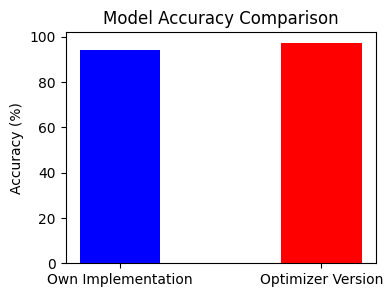

In [74]:
# Assuming the accuracy values are stored in variables `accuracy_own` and `accuracy_optim`
accuracy_own = 94.32
accuracy_optim = 97.17

# Plotting the accuracy comparison
plt.figure(figsize=(4, 3))
plt.bar(['Own Implementation', 'Optimizer Version'], [accuracy_own, accuracy_optim], color=['blue', 'red'], width=0.4)
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.savefig("mnist_accuracy_comparison.pdf", format="pdf")
plt.show()